In [15]:
import warnings
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from dotenv import load_dotenv
from omegaconf import OmegaConf
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

from transformer_lens import HookedTransformer, HookedTransformerConfig

sys.path.append(f'{os.getcwd()}/../')
from lm_polygraph.stat_calculators import EntropyCalculator
from prompts import w_context_user_prompt, w_context_system_prompt, wo_context_system_prompt
from utils import heatmap_uncertainty
load_dotenv()

[nltk_data] Downloading package treebank to
[nltk_data]     /home/a.boriskin/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/a.boriskin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
nq_dataset = pd.read_csv('../data/adaptive_rag_natural_questions.csv')

In [7]:
cfg = OmegaConf.load("../config.yaml")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(cfg.model_id)
model = HookedTransformer.from_pretrained(
    cfg.model_id,
    device=device,
    tokenizer=tokenizer,
)
model.set_use_attn_result(True)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.2-3B-Instruct into HookedTransformer


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-27): 28 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_att

In [38]:
def store_multiple_activations(activation_dict):
    def hook_fn(activation, hook):
        activation_dict[hook.name] = activation.detach()
    return hook_fn

def collect_activations(model, tokens):
    activation_dict = {}

    hooks = []
    for i in range(model.cfg.n_layers):
        for activation_name in ["hook_resid_post", "hook_attn_out", "hook_mlp_out"]:
            layer_name = f"blocks.{i}.{activation_name}"
            if layer_name in model.hook_dict:
                hooks.append((layer_name, store_multiple_activations(activation_dict)))

    with torch.no_grad():
        logits = model.run_with_hooks(tokens, return_type="logits", fwd_hooks=hooks)

    return activation_dict

In [33]:
def layer_wise_entropy(activation_dict, model, activation_name) -> torch.tensor:
    logit_lens = []
    estimator = EntropyCalculator()
    
    for state in range(model.cfg.n_layers):
        activation = activation_dict[f"blocks.{state}.{activation_name}"]  # [batch, seq_len, d_model]
        logits = model.ln_final(activation)  # [batch, seq_len, d_model]
        logits = model.unembed(logits)  # [batch, seq_len, vocab_size]
        last_token_resid = logits[:, -1, :]
        log_probs = F.log_softmax(last_token_resid, dim=-1).detach().cpu().unsqueeze(dim=0)
        uncertainty = estimator({"greedy_log_probs": np.array(log_probs)})['entropy'][0][0] # only first token
        logit_lens.append(uncertainty)
        
    return torch.tensor(logit_lens)  # [n_layers]

In [34]:
import matplotlib.pyplot as plt

def plot_entropy_comparison(entropy_results):
    plt.figure(figsize=(10, 5))

    for activation_name, entropy_values in entropy_results.items():
        plt.plot(range(len(entropy_values)), entropy_values.numpy(), label=activation_name)

    plt.xlabel("Layer")
    plt.ylabel("Entropy")
    plt.title("different activations on 1 token")
    plt.legend()
    plt.grid()
    plt.show()

In [32]:
def analyze_and_visualize_entropy(text, model, tokenizer):
    tokens = model.to_tokens(text, prepend_bos=False).to(device)
    activation_dict = collect_activations(model, tokens)

    entropy_results = {
        "hook_resid_post": layer_wise_entropy(activation_dict, model, "hook_resid_post"),
        "hook_attn_out": layer_wise_entropy(activation_dict, model, "hook_attn_out"),
        "hook_mlp_out": layer_wise_entropy(activation_dict, model, "hook_mlp_out"),
    }

    plot_entropy_comparison(entropy_results)

In [41]:
test = nq_dataset.iloc[11]
print(test['question'])
print(test['reference'])

test_wc = tokenizer.apply_chat_template([
    {"role": "user", "content": w_context_user_prompt(test['question'], test['context'])}, 
    {"role": "system", "content": w_context_system_prompt()}
], tokenize=False, add_generation_prompt=True)

test_woc = tokenizer.apply_chat_template([
    {"role": "user", "content": test['question']}, 
    {"role": "system", "content": wo_context_system_prompt()}
], tokenize=False, add_generation_prompt=True)
            

when does justice leavue come out on dvd
March 13 , 2018


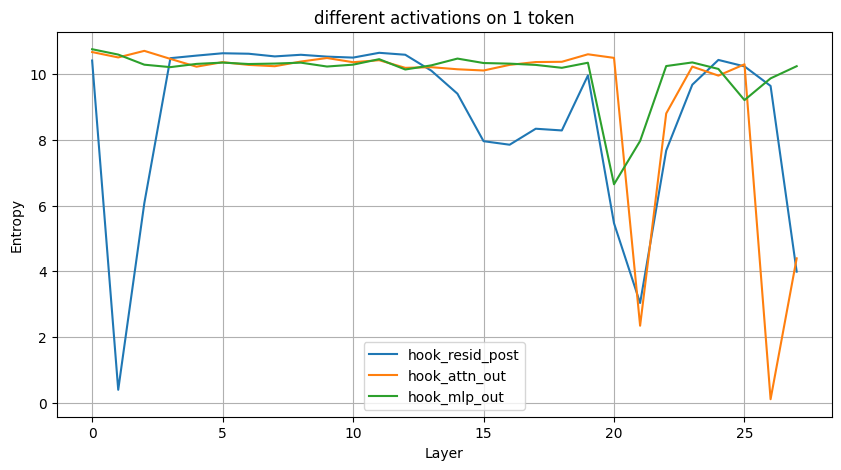

In [42]:
text_example = "Какова столица Франции?"
analyze_and_visualize_entropy(text_example, model, tokenizer, )